# Appendix A:  Analytics output 

In [1]:
#!pip install pymysql venn seaborn pandasql plotly psutil
import os
import pandas as pd, numpy as np
import seaborn as sns
import venn
from sqlalchemy import create_engine, text
from pandasql import sqldf

ModuleNotFoundError: No module named 'seaborn'

In [2]:
#database credentials and connection information 
db_user = os.getenv('DATABASE_USERNAME')
db_password = os.getenv('DATABASE_PASSWORD')
#db_host = 'jnj-lci.cluster-ckwbormwta82.us-east-1.rds.amazonaws.com'
db_host = 'jnj-lci-8.ckwbormwta82.us-east-1.rds.amazonaws.com'
db_name = 's4_curated_dataset_lci'
db_url = f'mysql+pymysql://{db_user}:{db_password}@{db_host}:3306/{db_name}'

#connect to database
engine = create_engine(db_url)
connection = engine.connect()

NameError: name 'create_engine' is not defined

## I. Base study population
Request:
* Patients with an ICD code for lung cancer (LCa) diagnosis (~13,000 patients) in the Mt. Sinai database are the base population for this study. 
* This broad cohort is divided into 3 cohorts as shown below.
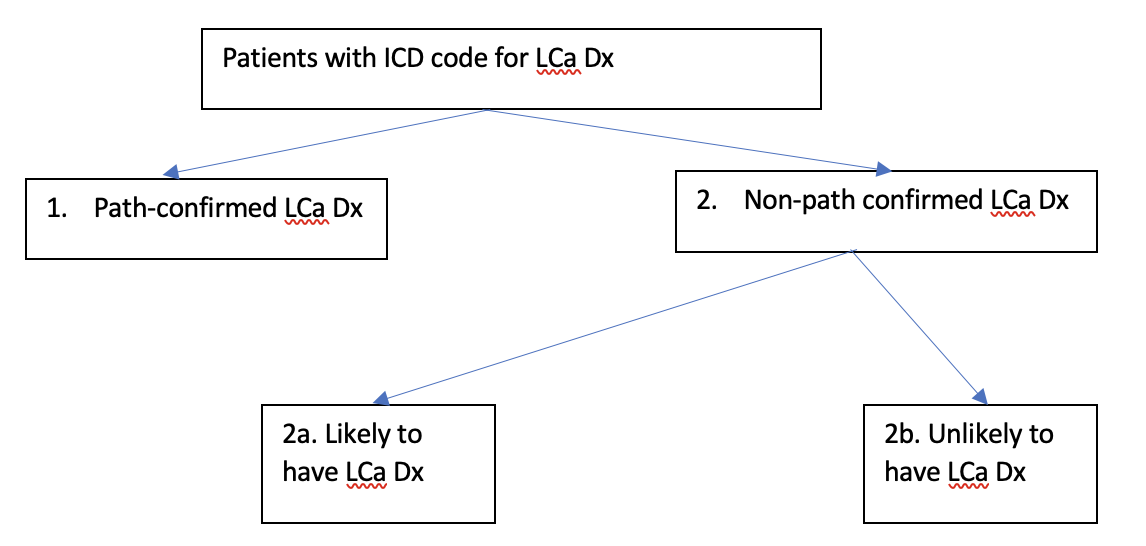

Approach: see IV.1 below.

## II. Full study period
Request: All data available 2003-December 2020.

Approach:
* The database contains some data out of the study range.
* For the GGO analyses, all patient with the first CT chest scan before 2003 or after 2020 are excluded.

## III. GGO cohort specification
Requests: 
* Patient to be 18 years of age or older as on date of first chest CT or LDCT scan.  
* Patients with reported GGOs on at least one radiology report/progress notes/other clinical document. 

Approach:  
* For the analyses, patients younger than 18 yo at the first ‘CT chest’ radiology reports are excluded. 
* Only patients with recognized GGO term (ggo_level_1 like ‘GGO_term’ in notes_ggo table) are included in the analyses.

## IV. Requested outputs as part of Phase 1

## IV.1 For overall cohort of ~13,000 patients with an ICD Dx code for lung cancer
Approach:
* ICD codes for lung cancer used: 
    * ICD-10: C34 
    * ICD-9: 162 

### 1.a Definition for sub cohorts
Approach: 
* Define the three mutually exclusive cohorts as below: 
    * Path-confirmed: patients have cancer_type=1 in the 'cancer_diagnoses' table 
    * Likely LCa: patients who were not path-confirmed to have LCa and on >= 3 visits with an LCa ICD code  
    * Unlikely LCa: patients who were not path-confirmed to have LCa and on < 3 visits with an LCa ICD
* Then exclude the patients with LCa diagnosis (first path-confirmed report if available, otherwise first ICD report) reported earlier than 2003 or later than 2020. 

Results: 
* The cohort info can be found in the view: v_s4_lca_cohort 

### 1.b Sample count of sub cohorts (cohorts are mutually exclusive)
Summary:

In [5]:
confirmed = """SELECT distinct d_person_id 
    FROM cancer_diagnoses where cancer_type_id = 1
    """
other = f"""SELECT d_person_id, count(distinct(event_date)) as n_days_with_lca_diagnosis
    FROM person_icd_codes 
    where (icd_code like 'C34%' or icd_code like '162%')
        and d_person_id not in ({confirmed})
    GROUP BY d_person_id
    """
select = f"""SELECT d_person_id, 'path-confirmed' as cohort 
    FROM ({confirmed}) as confirmed
    UNION ALL
    SELECT d_person_id, 'likely' as cohort 
    FROM ({other}) as other
    where n_days_with_lca_diagnosis >= 3 
    UNION ALL
    SELECT d_person_id, 'unlikely' as cohort
    FROM ({other}) as other
    where n_days_with_lca_diagnosis < 3
    """
tmp = connection.execute(text(f"""create or replace view v_s4_lca_cohort as
    {select}"""))

In [9]:
pd.read_sql("select count(*) total_patients from v_s4_lca_cohort",
                 connection, index_col='total_patients')

""
total_patients
13216


In [10]:
# checking
pd.read_sql("select cohort, count(*) patients from v_s4_lca_cohort group by cohort",
            connection, index_col='cohort')

,patients
cohort,
path-confirmed,6603
likely,2458
unlikely,4155


### 1.c Summary statistics of CT scans for each of the cohorts (distribution of CT scans, median, average scans per patient during study period)
Approach:
* Using 'CT chest' records in the radiologies table.

Summary:

In [11]:
tmp=connection.execute(text(r"""
    create or replace view _ct_chest as
    select * from radiologies
    where imaging_study like '%CT%' and location like '%Chest%'
    """))

In [12]:
cohort_order=['path-confirmed', 'likely', 'unlikely']
describe_order = ['mean', 'min', '25%', '50%', '75%', 'max']

In [13]:
data = pd.read_sql("""
    select d_person_id, cohort
    , count(distinct radiology_date) ct_scans
    from v_s4_lca_cohort
    join _ct_chest using(d_person_id)
    group by d_person_id, cohort
    """, connection)
data.groupby('cohort')['ct_scans'].describe()\
    .loc[cohort_order, describe_order] 

,mean,min,25%,50%,75%,max
cohort,,,,,,
path-confirmed,5.106561,1.0,1.0,3.0,7.0,43.0
likely,4.951570,1.0,1.0,3.0,6.0,40.0
unlikely,3.804699,1.0,1.0,2.0,5.0,41.0


Finding:
* Patients in the path-confirmed and LCa likely cohorts tend to have more CT chests on average than those in the unlikely cohort (5 scans vs 4).
  
### 1.d Summary statistics for observation time (pre- and post LCa Dx) for each LCa patient cohort in the database
Approach: 
* LCa Dx date is defined as the first LCa Dx date in cancer_diagnoses if available, otherwise the first LCa ICD report date. 
* Observation time is defined by days from first visit date to Dx date (pre-Dx) or the last visit date to Dx date (post-Dx). (The last visit date has been updated with the refreshed database.) 

Summary: 

In [14]:
sql = r"""
with first_icd as (
    select d_person_id
    , min(event_date) first_icd_date
    , min(year_event_date) first_icd_year
    from person_icd_codes
    where (icd_code like 'C34%' or icd_code like '162%')
    group by d_person_id
), first_confirmed as (
    select d_person_id
    , min(date_of_diagnosis) first_confirmed_date
    , min(year_of_diagnosis) first_confirmed_year
    from cancer_diagnoses
    join cancer_types using (cancer_type_id)
    where cancer_type_name='LCA'
    group by d_person_id
)
select d_person_id
, coalesce(first_confirmed_date, first_icd_date) dx_date
, coalesce(first_confirmed_year, first_icd_year) dx_year
from first_icd
left join first_confirmed using (d_person_id)
"""
#pd.read_sql(sql, connection)

In [15]:
tmp = connection.execute(text(f"""create or replace view _lca_dx as
    {sql}
    """))
#pd.read_sql('select count(*) from _lca_dx', connection)

In [16]:
tmp = pd.read_sql("""
select * from _lca_dx
where dx_year>2020 or dx_year<2003
order by dx_year
""", connection)

In [17]:
tmp = pd.read_sql("""
select greatest(2,4,null), least(2, 4, null)
""", connection)

In [18]:
sql = """
with range_visit as (
    select d_person_id, min(visit_date) first_visit, max(visit_date) last_visit
    from visits
    group by d_person_id
), range_dx as (
    select d_person_id, min(event_date) first_dx, max(event_date) last_dx
    from person_icd_codes
    group by d_person_id
), range_proc as (
    select d_person_id, min(procedure_date) first_proc, max(procedure_date) last_proc
    from procedure_occurrences
    group by d_person_id
), range_med as (
    select d_person_id, min(date_of_medication) first_med, max(date_of_medication) last_med
    from medications
    group by d_person_id
)
-- select * from range_visit
select d_person_id
, cohort
, dx_date
, least(coalesce(first_visit, 99999)
    , coalesce(first_dx, 99999)
    , coalesce(first_proc, 99999)
    , coalesce(first_med, 99999)
    ) first_visit_date
, greatest(coalesce(last_visit, 0)
    , coalesce(last_dx, 0)
    , coalesce(last_proc, 0)
    , coalesce(last_med, 0)
    ) last_visit_date
from v_s4_lca_cohort
join _lca_dx using (d_person_id)
left join range_visit using (d_person_id)
left join range_dx using (d_person_id)
left join range_proc using (d_person_id)
left join range_med using (d_person_id)
group by d_person_id, cohort, dx_date
"""
# print(data.shape)
# some patients (n=201) has no visit data?
# data.first_visit_date.isna().sum()

In [19]:
connection.execute("drop table if exists _lca_range")
tmp = connection.execute(text(f"""
create table _lca_range as 
{sql}
"""))

In [20]:
#debug
tmp = pd.read_sql("""
    select count(distinct d_person_id) patients
    from v_s4_lca_cohort
    left join visits using (d_person_id)
    where visit_date is null
    """, connection)

In [21]:
#debug
tmp = pd.read_sql("""
    select dx_date is not null, count(distinct d_person_id)
    from _lca_dx
    group by dx_date is not null
    """, connection)

In [22]:
# debug
tmp = pd.read_sql("""
    select d_person_id
    , min(event_date) first_icd_date
    from person_icd_codes
    where (icd_code like 'C34%' or icd_code like '162%')
    group by d_person_id
    """, connection)
# tmp.first_icd_date.isna().sum()

In [23]:
tmp = pd.read_sql("""
    select d_person_id
    , min(event_date) first_icd_date
    from person_icd_codes
    where (icd_code like 'C34%' or icd_code like '162%')
        and event_date is not null
    group by d_person_id
    """, connection)
# tmp.first_icd_date.isna().sum() #353
# len(tmp) #12863

In [24]:
data = pd.read_sql("""
select * from _lca_range
""", connection)

In [25]:
data = pd.concat([
        data.assign(followup_days=data.dx_date-data.first_visit_date+1, followup_type='pre_dx'),
        data.assign(followup_days=data.last_visit_date-data.dx_date+1, followup_type='post_dx'),
])

In [26]:
#quick check # more thorough check later.
followup_days = data.followup_days
#sum(followup_days.isna())
#followup_days = data.followup_days.fillna()
#sum(data.first_visit_date.isna())
#sum(data.last_visit_date.isna())
# sum(data.dx_date.isna()) #686

In [27]:
tmp = pd.read_sql("""
select count(*) from _lca_dx where dx_date is null
""", connection)
#343

In [28]:
#quickfix the outliers
followup_days = data.followup_days.fillna(0)
followup_days[followup_days<0] = 0
data = data.assign(followup_days=followup_days)
followup_days[followup_days<1] = 1
data = data.assign(log10_followup_days=np.log10(followup_days))
#data.shape

In [29]:
#summary
followup_type_order = ['pre_dx', 'post_dx']
#print ('Summary statistics for follow up days in Log10 scale:')
#summ = data.groupby(['cohort', 'followup_type']).log10_followup_days.describe()
summ = data.groupby(['cohort', 'followup_type']).followup_days.describe()
multi_index = pd.MultiIndex.from_product([cohort_order, followup_type_order])
summ.reindex(multi_index)[describe_order]

mean  min     25%     50%      75%      max
path-confirmed pre_dx   1234.503862  0.0    7.00    96.0  1770.00  31607.0
               post_dx  1540.347266  0.0  450.00  1162.0  2208.50  12936.0
likely         pre_dx   1226.412124  1.0   15.00   539.0  1838.75  29174.0
               post_dx  1214.913344  3.0  286.75   886.0  1864.75   7712.0
unlikely       pre_dx   1052.571360  0.0    2.00   189.0  1561.00  28594.0
               post_dx   819.564140  0.0   20.00   358.0  1288.00   6856.0

Visualization:
* A violin plot: the y axis is observation days in log10 scale.

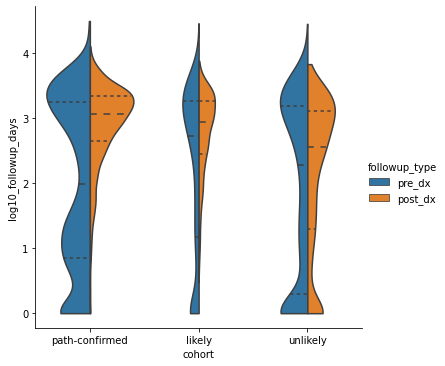

In [30]:
#plot
g = sns.catplot(data=data, kind='violin',
                x="cohort", y="log10_followup_days", 
                        hue="followup_type", hue_order=followup_type_order,
                        split=True,
                        inner="quartile",
                        scale="count" ,scale_hue = False, cut=0,
                  )

Finding:
* The path-confirmed LCa patients have longer followup time after Dx, but shorter observation time before Dx, compared with the other two cohorts (statistic tests not performed). 

## IV 2: For GGO cohort (cohort of patients that meet GGO cohort specifications per above in III)

Approach: see section III.
Summary:
* Unique patient count for the GGO cohort - breakdown of these numbers for each LCa cohort

In [32]:
# filter patients by age>=18 at the first ct chest
first_ct_chest = pd.read_sql("""
select d_person_id
, min(radiology_date) first_ct_chest_date
, min(year_radiology_date) first_ct_chest_year
, cast(floor(min(radiology_date)/365.25) as signed) first_ct_chest_age
from _ct_chest
group by d_person_id
""", connection)
#7019 (50%) patients has any ct_chest report
sqldf("""
    select count(*)
    from first_ct_chest
    where first_ct_chest_age<18 or first_ct_chest_year not between 2003 and 2020
    """, locals())
# 83 patients will be fitered off

,count(*)
0,83


In [16]:
# precheck the notes_ggo
# pd.read_sql("""select * from notes_ggo limit 100""", connection)
pd.read_sql(text("""
    select count(distinct d_person_id) total_patients
    from notes_ggo 
    join v_s4_lca_cohort using (d_person_id)
    where ggo_level1 like 'GGO_term%'
        and dx_date/365
    """), connection)

,total_patients_from_notes_ggo
0,4513


In [35]:
# create the assistant table
sql = """
    with ggo_note as (
        select distinct d_person_id, note_date, radiology_id is not null as is_radiology
        from notes_ggo
        where GGO_level1 like 'GGO_term%'
        order by d_person_id, note_date, is_radiology
    ), first_ggo as (
        select d_person_id
        , min(note_date) first_ggo_date
        from ggo_note
        group by d_person_id
    ), first_ct_chest as (
       select d_person_id
        , cast(floor(min(radiology_date)/365.25) as signed) first_ct_chest_age
        , min(year_radiology_date) first_ct_chest_year
        from _ct_chest
        group by d_person_id 
    ), cohort as (
        select d_person_id
        , first_ggo_date
        from first_ggo
        left join first_ct_chest using(d_person_id)
        where (first_ct_chest_age is null or first_ct_chest_age >= 18)
            and (first_ct_chest_year is null or first_ct_chest_year between 2003 and 2020)
    ), patient_ggo_rads as (
        select d_person_id
        , count(distinct note_date) ggo_rads
        from ggo_note
        where is_radiology
        group by d_person_id
    ), patient_ggo_other as (
        select d_person_id
        , count(distinct note_date) ggo_other
        from ggo_note
        where not is_radiology
        group by d_person_id
    ), patient_rads as (
        select d_person_id
        , count(distinct radiology_date) rads -- consider rads reported in the same day as one
        from radiologies
        group by d_person_id
    )
    -- select *
    select d_person_id, cohort, first_ggo_date
    , coalesce(rads, 0) total_radiology_reports
    , coalesce(ggo_rads, 0) radiology_reports_with_ggo
    , coalesce(ggo_other, 0) other_reports_with_ggo
    -- , first_scan_date, last_scan_date -- nullable
    from cohort
    left join patient_rads using (d_person_id)
    left join patient_ggo_rads using (d_person_id)
    left join patient_ggo_other using (d_person_id)
    -- left join patient_first_last_scan using (d_person_id)
    join v_s4_lca_cohort using (d_person_id)
    """
tmp = connection.execute(text(f"""
    create or replace view _patient_ggo as 
    {sql}"""))
#patient_ggo = pd.read_sql(text(sql), connection)
#patient_cohort = pd.read_sql("select * from v_s4_lca_cohort", connection)
#data = sqldf("""select * from patient_ggo join patient_cohort using (d_person_id)""", locals())
#patient_ggo

In [59]:
data = pd.read_sql("select * from _patient_ggo",
                   connection) 

In [44]:
pd.DataFrame(dict(total_patients=[len(data)])).set_index('total_patients')

""
total_patients
4474


In [45]:
#summary --to be refined later
data.set_index(['d_person_id']).groupby(['cohort']).size().to_frame(name='patients').loc[cohort_order, :]

,patients
cohort,
path-confirmed,3104
likely,694
unlikely,676


### 2a. Total number of radiology reports available, number of (radiology) reports with GGO findings – breakdown of these numbers for each LCa sub-cohort
Approach: 
* Radiology reports are counted for each patient from the radiologies table.
* GGO reports are counted for each patient from the notes_ggo table.
    * Radiology reported in the same day are counted as one report.
    * Other notes reported in the same day are counted as one report. 
Summary: 

In [46]:
report_type_order = ['total_radiology_reports', 'radiology_reports_with_ggo', 'other_reports_with_ggo']
data_melt = data.melt(id_vars=['d_person_id', 'cohort'],
          value_vars=report_type_order,
          var_name='report_type', value_name='reports')
summ = data_melt.set_index(['d_person_id']).groupby(['cohort', 'report_type']).reports.describe()
multi_index = pd.MultiIndex.from_product([cohort_order, report_type_order])
summ.reindex(multi_index)[describe_order]

mean  min  25%   50%   75%  \
path-confirmed total_radiology_reports     21.021585  0.0  8.0  16.0  29.0   
               radiology_reports_with_ggo   2.360180  0.0  1.0   1.0   3.0   
               other_reports_with_ggo       3.872101  0.0  0.0   1.0   4.0   
likely         total_radiology_reports     17.337176  0.0  3.0  11.0  25.0   
               radiology_reports_with_ggo   1.684438  0.0  0.0   1.0   2.0   
               other_reports_with_ggo       3.257925  0.0  0.0   1.0   3.0   
unlikely       total_radiology_reports     19.576923  0.0  4.0  13.0  27.0   
               radiology_reports_with_ggo   1.539941  0.0  1.0   1.0   2.0   
               other_reports_with_ggo       3.026627  0.0  0.0   1.0   3.0   

                                             max  
path-confirmed total_radiology_reports     152.0  
               radiology_reports_with_ggo   28.0  
               other_reports_with_ggo      109.0  
likely         total_radiology_reports     123.0  
               radiology_reports_with_ggo   28.0  
               other_reports_with_ggo       64.0  
unlikely       total_radiology_reports     182.0  
               radiology_reports_with_ggo    9.0  
               other_reports_with_ggo       80.0

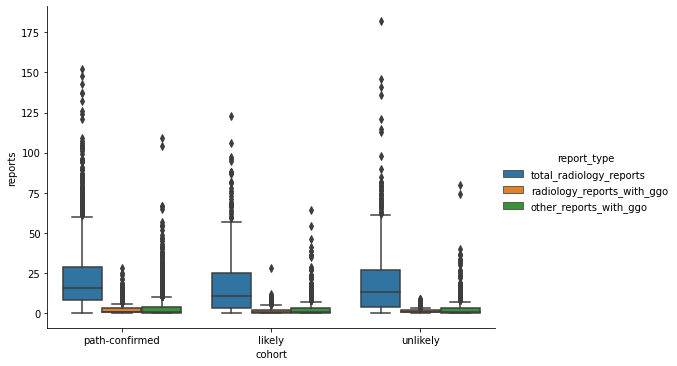

In [47]:
# plot
g = sns.catplot(data=data_melt, kind='box', #.assign(log10_of_reports=np.log10(data_melt.reports+1)),
            x="cohort", order=cohort_order,
            y="reports", #y="log10_of_reports",
            hue="report_type", hue_order=report_type_order,
            aspect=1.4
            )

Visualization:
* Box plots of each type of reports per patient, stratified by cohorts.
 
Finding: 
* The percentage of radiology reports with a GGO finding is higher in the path-confirmed and LCa-likely cohorts as compared to the LCa-unlikely cohort (11.3% path-confirmed vs 7.8% in unlikely). 

### 2.b. Distribution of follow-up scans for the GGO cohort (following index qualifying scan) in time, regardless of if a follow-up scan had GGO finding.
Approach: 
* Used the CT chest radiology reports after the index report of GGO (first GGO from radiology or other reports). 

Summary:  
* The distribution of the days between the index GGO report and the first CT chest scan after that day for each patient. 

Visualization: 
* A histogram of the same distribution:  days are on log10 scale. Note that a patient can be counted only in one bin.

In [48]:
sql = """
    select d_person_id, cohort
    , min(radiology_date-first_ggo_date) as closest_scan_post_ggo
    from _patient_ggo
    join _ct_chest using (d_person_id)
    where radiology_date>first_ggo_date
    group by d_person_id, cohort
    """
data = pd.read_sql(sql, connection)
#data

In [49]:
# summary
#data.set_index('d_person_id').groupby('cohort').closest_scan_post_ggo.describe().loc[cohort_order, describe_order]
data.set_index('d_person_id').describe().loc[describe_order, :]

,closest_scan_post_ggo
mean,234.089267
min,1.000000
25%,29.000000
50%,107.000000
75%,223.000000
max,4253.000000


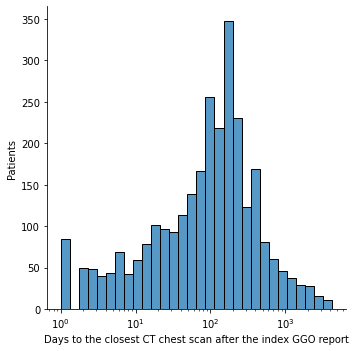

In [50]:
# plot
g = sns.displot(data, x='closest_scan_post_ggo', log_scale=True)
g = g.set_axis_labels('Days to the closest CT chest scan after the index GGO report', 'Patients')


### 2.c. Summary statistics for number of scans per patient with a GGO finding and distribution in time
Approach: 
* Radiology reports with a GGO finding are used for this analysis. 

Summary: 
* Distribution of the total GGO scans per patient. 
* Distribution of the timing (days) of GGO scans relative to LCa Dx date. (Negative days mean scans reported before the LCa Dx) 

Visualization: 
* A Histogram of the relative days from GGO scans to LCa Dx date for each patient.  Note that the y axis is count of patients with a scan within the relevant bin, and a patient could be counted in more than one bins (if have multiple GGO scans spanning multiple bins). 

Finding: 
* More GGO are reported after the Cancer Dx.
* About half of the GGO patients has a GGO finding within 50 days to the LCa Dx date. 

In [51]:
sql = """
with ggo_note as (
      select distinct d_person_id, note_date, radiology_id is not null as is_radiology
        from notes_ggo
        where GGO_level1 like 'GGO_term%'
        order by d_person_id, note_date, is_radiology
)
select d_person_id, cohort
, note_date - dx_date relative_day_to_dx
from ggo_note
join _patient_ggo using(d_person_id)
join _lca_dx using (d_person_id)
    where is_radiology
-- group by d_person_id, cohort
"""
data = pd.read_sql(text(sql), connection)
#data

In [52]:
# summary
data.groupby('d_person_id').size().describe().to_frame(name='GGO radiology reports per patient').loc[describe_order,:]

,GGO radiology reports per patient
mean,2.60191
min,1.00000
25%,1.00000
50%,2.00000
75%,3.00000
max,28.00000


In [53]:
data.relative_day_to_dx.describe().to_frame(name='Relative days of GGO scan to LCa Dx').loc[describe_order, :]

,Relative days of GGO scan to LCa Dx
mean,593.197414
min,-5455.000000
25%,3.000000
50%,240.000000
75%,938.000000
max,11984.000000


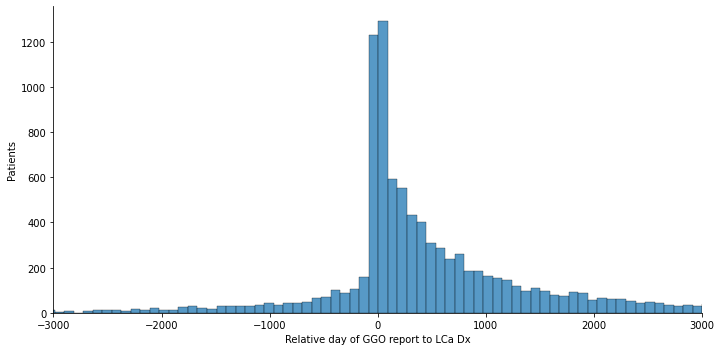

In [54]:
g = sns.displot(data=data,
            x='relative_day_to_dx',
            aspect=2,
           )
g = g.set(xlim=(-3000, 3000))
g = g.set_axis_labels('Relative day of GGO report to LCa Dx', 'Patients')

### 2.d. Assess temporality of report with GGO finding with respect to LCa Dx code:
Request: 
* Pre-LCa Dx period: # of scans with GGO findings in the pre-path confirmed LCa diagnosis date (for cohort 1), pre-‘proxy LCa’ confirmation date (for cohort 2a, 2b) 
* Post-LCa Dx period: GGO findings in scans occurring in the post-period for each cohort 

Approach: 
* Count number of radiology reports with a GGO finding before and after LCa diagnosis, respectively, for each patient.
* Then further stratify the counts by the three cohorts. 

Summary:
* Descriptive statistics of the counts above. Note that a patient could have GGO findings in both pre- and post- LCa Dx. 

Visualization:
* Split violin plots of the distribution of the number of GGO findings, stratified by cohort and pre/post-Dx. 

Finding: 
* The path-confirmed patients have more GGO finding post cancer Dx (average 2.6 vs 1.7 for unlikely). 

In [55]:
sql = """
with ggo_note as (
      select distinct d_person_id, note_date, radiology_id is not null as is_radiology
        from notes_ggo
        where GGO_level1 like 'GGO_term%'
        order by d_person_id, note_date, is_radiology
)
select d_person_id, cohort
, case when note_date < dx_date then 'pre_dx' else 'post_dx' end as ggo_timing
, count(*) ggo_scans
from ggo_note
join _patient_ggo using(d_person_id)
join _lca_dx using (d_person_id)
    where is_radiology
group by d_person_id, cohort, note_date < dx_date
"""
data = pd.read_sql(text(sql), connection)
#data

In [56]:
# summary
summ = data.set_index('d_person_id').groupby(['cohort', 'ggo_timing']).describe().ggo_scans
summ.reindex(pd.MultiIndex.from_product([cohort_order, followup_type_order]))[['count']+ describe_order]

count      mean  min  25%  50%  75%   max
path-confirmed pre_dx    743.0  1.698520  1.0  1.0  1.0  2.0  11.0
               post_dx  2295.0  2.642266  1.0  1.0  2.0  3.0  25.0
likely         pre_dx    192.0  1.848958  1.0  1.0  1.0  2.0   9.0
               post_dx   404.0  2.014851  1.0  1.0  1.0  2.0  23.0
unlikely       pre_dx    259.0  1.667954  1.0  1.0  1.0  2.0   9.0
               post_dx   357.0  1.705882  1.0  1.0  1.0  2.0   9.0

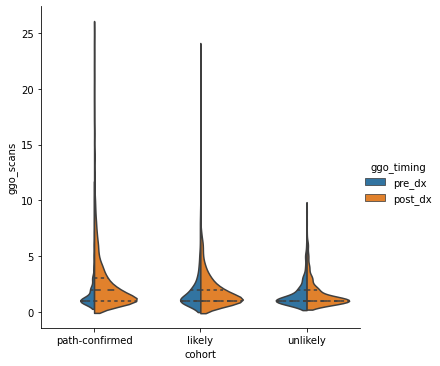

In [57]:
# plot
g = sns.catplot(data=data, kind='violin', #.assign(log2_ggo_scans=np.log2(data.ggo_scans)),
               x="cohort", order=cohort_order,
               y="ggo_scans",
               hue="ggo_timing", hue_order=followup_type_order,
               split=True,
               inner="quartile",
               scale='count'
              )

### 2.e. Observation time for the GGO cohort (pre- and post LCa Dx) in the database
Approach:
* Similar as in 1.d. 

Summary:
* Statistics for followup days in normal scale.

Visualization: 
* Split violin plots. 

Finding:
* Similar as in 1.d.

In [62]:
data = pd.read_sql(text("""
select d_person_id, lr.cohort, dx_date
, first_visit_date
, last_visit_date
from _patient_ggo pg
join _lca_range lr using (d_person_id)
"""), connection)
#data

In [63]:
data = pd.concat([
        data.assign(followup_days=data.dx_date-data.first_visit_date+1, followup_type='pre_dx'),
        data.assign(followup_days=data.last_visit_date-data.dx_date+1, followup_type='post_dx'),
])

In [64]:
#quickfix the outliers
followup_days = data.followup_days.fillna(0)
followup_days[followup_days<0] = 0
data = data.assign(followup_days=followup_days)

followup_days[followup_days<1] = 1
data = data.assign(log10_followup_days=np.log10(followup_days))
#data.shape

In [65]:
#summary
followup_type_order = ['pre_dx', 'post_dx']
summ = data.groupby(['cohort', 'followup_type']).followup_days.describe()
multi_index = pd.MultiIndex.from_product([cohort_order, followup_type_order])
summ.reindex(multi_index)[describe_order]

mean  min     25%     50%      75%      max
path-confirmed pre_dx   1479.848905  0.0   12.00   413.5  2304.00  31078.0
               post_dx  1681.759665  8.0  602.75  1323.5  2334.50  12936.0
likely         pre_dx   1433.881844  1.0   61.00   827.0  2169.75  24827.0
               post_dx  1297.005764  8.0  429.75  1010.5  1989.75   5599.0
unlikely       pre_dx   1612.559172  0.0   47.75   914.5  2342.00  26616.0
               post_dx  1121.550296  0.0  183.75   718.5  1681.25   6435.0

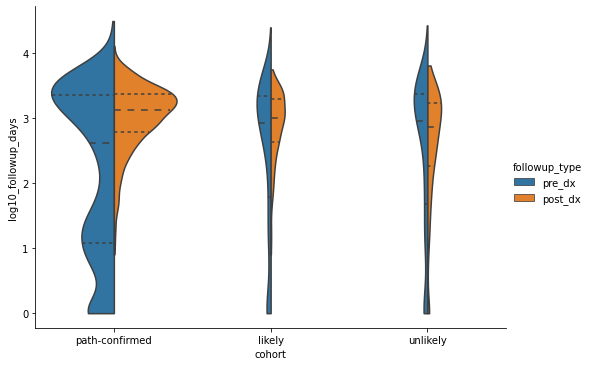

In [66]:
#plot
g = sns.catplot(data=data, kind='violin',
               x="cohort", order=cohort_order,
               y="log10_followup_days", 
               hue="followup_type", hue_order=followup_type_order,
               split=True,
               inner="quartile",
               scale="count" ,scale_hue = False, cut=0, aspect=1.4)

### 2.f. Distribution of CPT “incidental” vs. “screening” procedure codes (Table 1) for the GGO cohort
Approach:  
* CT chest scan type of incidental or screening is defined using the procedure codes according to the manually annotated reference table (ref_ggo_ct_type.csv) 
* CT chest scan reported within 30 days before or at date of the index GGO report are summarized 

Visualization:
* A Venn diagram of number of patients with incidental, or screening, or both (the overlapping area) types of CT chest scan reported as described above. 

Finding:
* The vast majority of patients with a GGO report have an incidental CT chest scan reported within a month before the index GGO report. 

In [67]:
tmp = pd.read_csv('../ref_ggo_ct_type.csv')
tmp.to_sql('ref_ggo_ct_type', con=connection, if_exists='replace')

In [68]:
data = pd.read_sql("""
    select distinct d_person_id, procedure_type
    from _procedure_ct_type
    join _patient_ggo using (d_person_id)
    where first_ggo_date > procedure_date
        and first_ggo_date-procedure_date<30
    """, connection)
#data

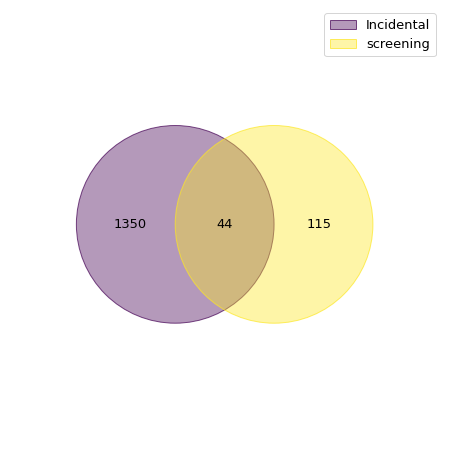

In [69]:
grouped = data.groupby('procedure_type')
data_ = {g: set(x['d_person_id']) for g, x in grouped}
g = venn.venn(data_)

### 2.g. Frequency distribution of ICD codes within (±) a 30-day window of the report with GGO finding (Table 2) if they appeared in structured data
Approach: 
* The ICD codes predefined in Table 2 were used to search the diagnoses table. 

Summary: 
* The number of patients matched any of the ICD code reported within 30 days before or after the index GGO report.
* The number of patients matched stratified by each ICD code. 

In [70]:
tmp = pd.read_csv('../ref_ggo_icd_cm.csv')
tmp.to_sql('ref_ggo_icd_cm', con=connection, if_exists='replace')

In [78]:
res = pd.read_sql(text("""
    with m as (
        select count(distinct d_person_id) patients
        from _patient_ggo p
        join person_icd_codes pi using (d_person_id)
        join ref_ggo_icd_cm r on pi.icd_code like concat(r.diagnosis_code, '%')
        where abs(event_date-first_ggo_date)<30
    ), total as (
        select count(distinct d_person_id) patients
        from _patient_ggo p
    )
    select m.patients matched_patients
    , m.patients/total.patients * 100.0 percentage_matched
    from m join total on 1
    """),  connection, index_col='matched_patients')
res

,percentage_matched
matched_patients,
1872,41.84175


In [79]:
# pd.read_sql("""select * from ref_ggo_icd_cm""", connection)
pd.read_sql(text("""
    select diagnosis_code, dx_description
    , count(distinct d_person_id) patients
    from _patient_ggo p
    join person_icd_codes pi using (d_person_id)
    join ref_ggo_icd_cm r on pi.icd_code like concat(r.diagnosis_code, '%')
    where abs(event_date-first_ggo_date)<30
    group by diagnosis_code, dx_description
    """), connection)

,diagnosis_code,dx_description,patients
0,518.89,other diseases of lung not elsewhere classified,595
1,519.8,"other diseases of respiratory system, not else...",3
2,519.9,unspecified disease of the respiratory system,20
3,786.6,"swelling, mass or lump in chest",436
4,793.1,Nonspecific abnormal findings on radiological ...,378
5,793.11,Solitary pulmonary nodule,280
6,793.19,Other nonspecific abnormal finding of lung field,121
7,R91,Abnormal findings on diagnostic imaging of lung,1290
8,R91.1,Solitary pulmonary nodule,754
9,R91.8,Other nonspecific abnormal finding of lung field,759


Finding: 
* The most reported ICD codes within one month around the index GGO report is R91.

### 2.h. Frequency distribution of each GGO concept/characteristic 

Approach:
* The GGO relevant entities recognized by the NLP pipeline, are normalized to categories defined by experts from J&J, for each of the following semantic groups. 

### 2.h - Potential causes:  
Summary:
* Patients with each category ever reported. 

Visualization:
* A Venn diagram of number of patients with one or more categories reported. Overlapping means those patients have more than one category ever reported. 

In [42]:
data = pd.read_sql("""
    select GGO_level2 GGO_potential_cause
    , count(distinct d_person_id) patients
    from notes_ggo
    where GGO_level1='GGO_potential_cause'
    group by GGO_level2
    """, connection)
data

,GGO_potential_cause,patients
0,infectious_inflammatory,1643
1,malignant neoplasm,1050
2,other,979
3,premalignancy,110


In [43]:
data = pd.read_sql("""
    select d_person_id, GGO_level2
    , count(*)
    from notes_ggo
    where GGO_level1='GGO_potential_cause'
    group by d_person_id, GGO_level2
    """, connection)
#data

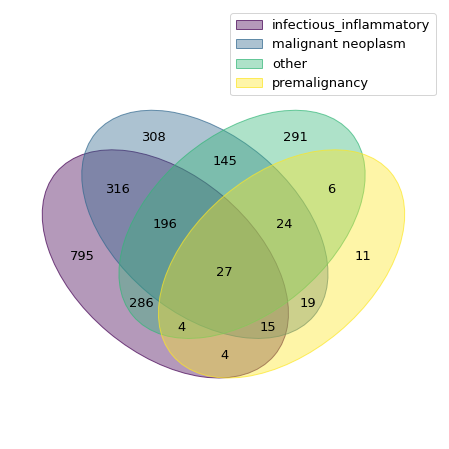

In [44]:
grouped = data.groupby('GGO_level2')
data_ = {g: set(x['d_person_id']) for g, x in grouped}
g = venn.venn(data_)

Finding: 
* The most reported potential causes are infectious/inflammatory and malignancy, and a substantial proportion of those patients have both causes reported (half of those with malignancy causes also with malignancy causes). 

### 2.h - GGO_size 
Summary:  
* Patients with each category ever reported. 
* A frequency table summarizing number of patients with each category at baseline and endpoint.  Note that 
    * Patients with GGO size reported in only a single date are excluded. 
    * The largest category is used if there are more than one category reported in the same day. 

Visualization:
* A 2d-histogram with size in mm at baseline (x) and endpoint (y).  Note that 
    * Patients with GGO size available in only single date are excluded from the plot 
    * The largest size is used if there are more than one GGO sizes reported in the same day. 
    * The GGO sizes are in log10 scale
    * the boxplots summarized the distribute for baseline and endpoint respectively. 
    * Blue line is for 6mm and red line for 20 mm 
    * The color scale is for number of patients in that bin (square) 

In [41]:
tmp = pd.read_sql("""
    select GGO_level2 GGO_size_category
    , count(distinct d_person_id) patients
    from notes_ggo
    where GGO_level1='GGO_size' and GGO_level2 is not null -- quickfix
    group by GGO_level2
    """, connection)

In [42]:
cat_order = ['<6mm(0.6cm)', '6-20mm(0.6-2cm)', '>20mm(2cm)']
tmp.set_index('GGO_size_category').loc[cat_order, :]

,patients
GGO_size_category,
<6mm(0.6cm),1045
6-20mm(0.6-2cm),1853
>20mm(2cm),716


In [33]:
data = pd.read_sql("""
with _res as (
    select distinct d_person_id person_id
    , GGO_level2 ggo_size_category
    , cast(GGO_level3 as float) ggo_size_in_mm
    , note_date ggo_date
    from notes_ggo
    where GGO_level1='GGO_size' and note_date is not null 
        and GGO_level3 is not null
), res as (
    select *
    from _res
    where ggo_size_in_mm < 1000 -- quickfix the outliers
), earliest as (
    select person_id
    , ggo_size_in_mm
    , ggo_size_category
    , ggo_date
    from (select *, row_number() over (
            partition by person_id
            order by ggo_date, ggo_size_in_mm desc) rn
        from res) tmp
    where rn=1
), latest as (
    select person_id
    , ggo_size_in_mm
    , ggo_size_category
    , ggo_date
    from (select *, row_number() over (
            partition by person_id
            order by ggo_date desc, ggo_size_in_mm desc) rn
        from res) tmp
    where rn=1
)
select person_id
, earliest.ggo_size_in_mm baseline_ggo_size_in_mm
, earliest.ggo_size_category baseline_ggo_size_category
, latest.ggo_size_in_mm latest_ggo_size_in_mm
, latest.ggo_size_category latest_ggo_size_category
from earliest
join latest using (person_id)
where earliest.ggo_date != latest.ggo_date
;
""", connection)
#data
#data.baseline_ggo_size_in_mm.plot()

In [39]:
cat = sqldf("""
    select baseline_ggo_size_category, latest_ggo_size_category
    , count(distinct person_id) patients
    from data
    where baseline_ggo_size_category is not null
        and latest_ggo_size_category is not null
    group by baseline_ggo_size_category, latest_ggo_size_category

    """, locals())

cat.pivot('baseline_ggo_size_category', 'latest_ggo_size_category', 'patients').loc[cat_order, cat_order]

latest_ggo_size_category,<6mm(0.6cm),6-20mm(0.6-2cm),>20mm(2cm)
baseline_ggo_size_category,,,
<6mm(0.6cm),117,100,27
6-20mm(0.6-2cm),90,694,113
>20mm(2cm),25,93,165


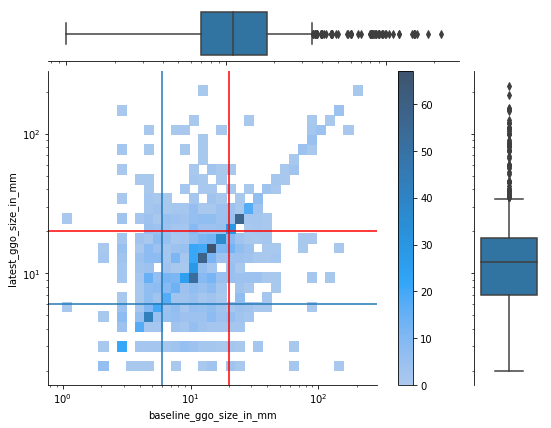

In [47]:
g = sns.JointGrid(data=data, x="baseline_ggo_size_in_mm", y='latest_ggo_size_in_mm')
g.plot_joint(sns.histplot, cbar=True, log_scale=True)
g.plot_marginals(sns.boxplot)
g.ax_joint.axvline(6)
g.ax_joint.axhline(6)
g.ax_joint.axhline(20, color='red')
g.ax_joint.axvline(20, color='red')
g.fig.set_figwidth(8)

Findings: 
* The median GGO sizes among all relevant patients are smaller at endpoint (see the boxplots). 
* In cases where the baseline GGO size is large (>20mm), they are more likely to be treated and have a mediate/small size reported at the endpoint (see the bottom right corner split by the red lines). 
  
### 2.h - GGO_location 
Summary:
* Number of patients with each location category ever reported. Level2: left/right, Level3: lower/upper. 

Visualization:
* A Venn diagram of patients with one or more categories ever reported at level2 (left/right lung). 

In [48]:
pd.read_sql("""
    select GGO_level2 GGO_location_level2, GGO_level3 GGO_location_level3
    , count(distinct d_person_id) patients
    from notes_ggo
    where GGO_level1='GGO_location' and GGO_level2 is not null -- quickfix
    group by GGO_level2, GGO_level3
    """, connection)

,GGO_location_level2,GGO_location_level3,patients
0,bilateral/all/both lungs,None,899
1,left lung,lower,1093
2,left lung,other,457
3,left lung,upper,1831
4,right lung,lower,1521
5,right lung,middle,657
6,right lung,other,623
7,right lung,upper,2117
8,unknown/subpleural/unspecified location,None,774


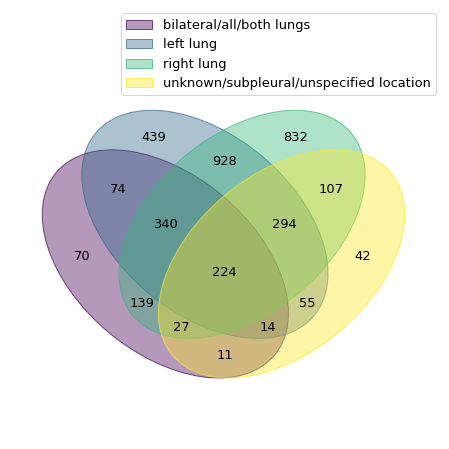

In [49]:
data = pd.read_sql("""
    select d_person_id, GGO_level2
    , count(*)
    from notes_ggo
    where GGO_level1='GGO_location'
    group by d_person_id, GGO_level2
    """, connection)
#data
grouped = data.groupby('GGO_level2')
data_ = {g: set(x['d_person_id']) for g, x in grouped}
g = venn.venn(data_)

Findings: 
* Not surprisingly, more patients reported as right lung only vs left lung only. 
* There are more patients reported as left and right separately, than those reported as ‘both lungs’. 

### 2.h - GGO number 
Visualization:
* A Venn diagram of patients with each category ever reported. 

Finding:
* Most patients are reported to have multiple GGOs. 

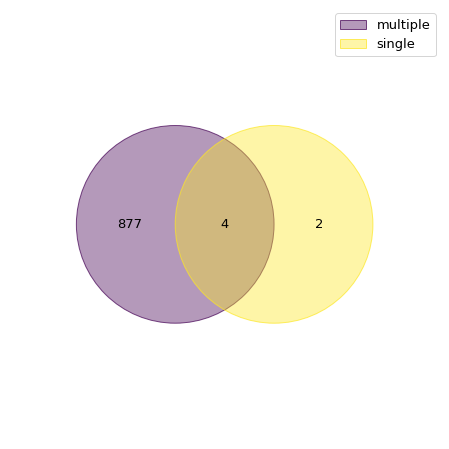

In [50]:
data = pd.read_sql("""
    select d_person_id, GGO_level2
    , count(*)
    from notes_ggo
    where GGO_level1='GGO_number'
    group by d_person_id, GGO_level2
    """, connection)
#data
grouped = data.groupby('GGO_level2')
data_ = {g: set(x['d_person_id']) for g, x in grouped}
g = venn.venn(data_)

### 2.h - GGO shape margin
Visualization:
* A Venn diagram of patients with each category ever reported  

Findings:  
* A vast majority of the patients are only reported as have irregular shape of GGO margins.  
* Lobulated shape is rarely reported. 

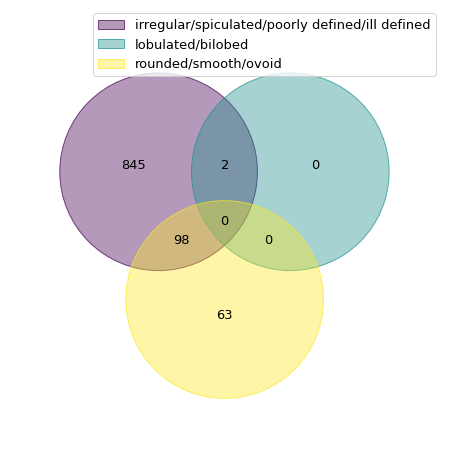

In [51]:
data = pd.read_sql("""
    select d_person_id, GGO_level2
    , count(*)
    from notes_ggo
    where GGO_level1='GGO_shape_margin'
    group by d_person_id, GGO_level2
    """, connection)
#data
grouped = data.groupby('GGO_level2')
data_ = {g: set(x['d_person_id']) for g, x in grouped}
g= venn.venn(data_)

### 2.h - GGO term
Visualization:
* A Venn diagram of patients with each category ever reported. 

Findings: 
* A vast majority of the patients are only reported as have GGO mixed (with a solid part).  
* Most patients with a pure GGO reported also have been reported as ‘mixed.’ 

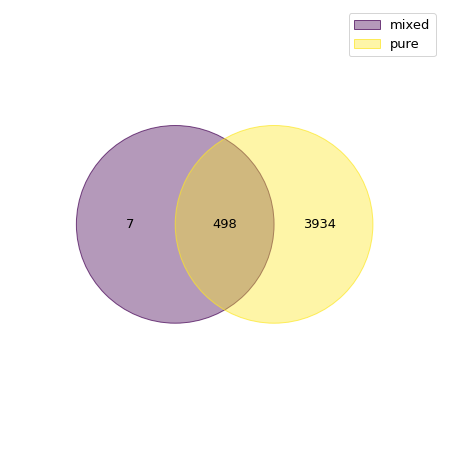

In [52]:
# ggo_term
data = pd.read_sql("""
    select d_person_id, GGO_level2
    , count(*)
    from notes_ggo
    where GGO_level1='GGO_term'
    group by d_person_id, GGO_level2
    """, connection)
#data
grouped = data.groupby('GGO_level2')
data_ = {g: set(x['d_person_id']) for g, x in grouped}
g=venn.venn(data_)

### 2.h - GGO solidity change
Approach: 
* Only the solidity changes directly extracted from notes are included in this report. 

Visualization: 
* A Venn diagram of number of patients with each category ever reported. 

Findings: 
* GGO solidity changes are rarely reported explicitly in the radiology notes. 
* If reported, it is usually reported as increased solidity.

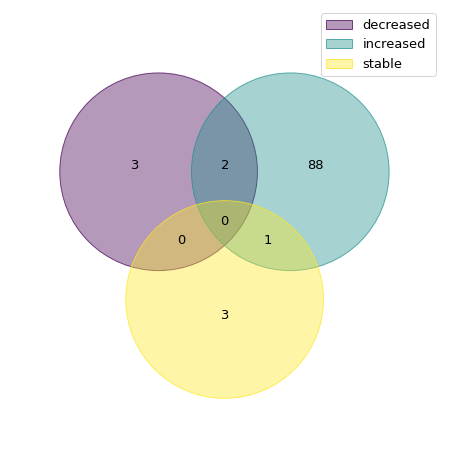

In [53]:
# ggo_solidity
data = pd.read_sql("""
    select d_person_id, GGO_level2
    , count(*)
    from notes_ggo
    where GGO_level1='GGO_solidity'
    group by d_person_id, GGO_level2
    """, connection)
#data
grouped = data.groupby('GGO_level2')
data_ = {g: set(x['d_person_id']) for g, x in grouped}
g=venn.venn(data_)

### 2.h - GGO status change
Visualization:   
* A Venn diagram of number of patients with each category ever reported. 

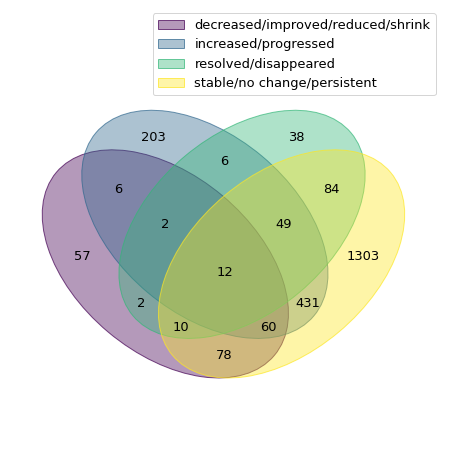

In [54]:
# ggo_status_change
data = pd.read_sql("""
    select d_person_id, GGO_level2
    , count(*)
    from notes_ggo
    where GGO_level1='GGO_status_change'
    group by d_person_id, GGO_level2
    """, connection)
#data
grouped = data.groupby('GGO_level2')
data_ = {g: set(x['d_person_id']) for g, x in grouped}
g=venn.venn(data_)

* Visualize the temporality (sequence of status changes) as Sankey diagram. Note that 
    * The most severe status change (see order below) is picked if more than one reported in a day. 
    * Only the patients with more than one status change reports are plotted. 
    * For each patient with more than ten status change reports, only the first ten status change reports are plotted. 

In [57]:
# sankey diagram
_status_change_order = pd.DataFrame(list(enumerate(['resolved/disappeared',
                       'decreased/improved/reduced/shrink',
                       'stable/no change/persistent',
                       'increased/progressed']))
                        , columns=['GGO_level2_order', 'GGO_level2'])
#_status_change_order.to_sql('_status_change_order', connection)
_status_change_order

,GGO_level2_order,GGO_level2
0,0,resolved/disappeared
1,1,decreased/improved/reduced/shrink
2,2,stable/no change/persistent
3,3,increased/progressed


In [58]:
df = pd.read_sql("""
with pick as (   
    select d_person_id, note_date
    , max(GGO_level2_order) GGO_level2_order
    from notes_ggo
    join _status_change_order using (GGO_level2)
    where GGO_level1='GGO_status_change' and GGO_level2 is not null and note_date is not null
    group by d_person_id, note_date
), raw as (
    select d_person_id, note_date, GGO_level2
    from pick
    join _status_change_order using (GGO_level2_order)
), first_ten as (
    select d_person_id person_id
    , substring(GGO_level2, 1, 3) cat
    , rnk
    from (select *, row_number() over (
            partition by d_person_id
            order by note_date) rnk
        from raw
        ) tmp
    where rnk < 10+1
)
select * 
from first_ten
order by person_id, rnk, cat
""", connection)
#df.to_csv('test_sankey.csv')

In [59]:
#!pip install psutil
#import psutil
from sankey import sankey_from_person_cat_rnk
g = sankey_from_person_cat_rnk(df)
g.write_html('status_change_first_10.html')
#g.write_image('status_change_first_10.png')

In [60]:
from IPython.display import HTML
#HTML(filename='status_change_first_10.html')

<!-- * a saved static version -->
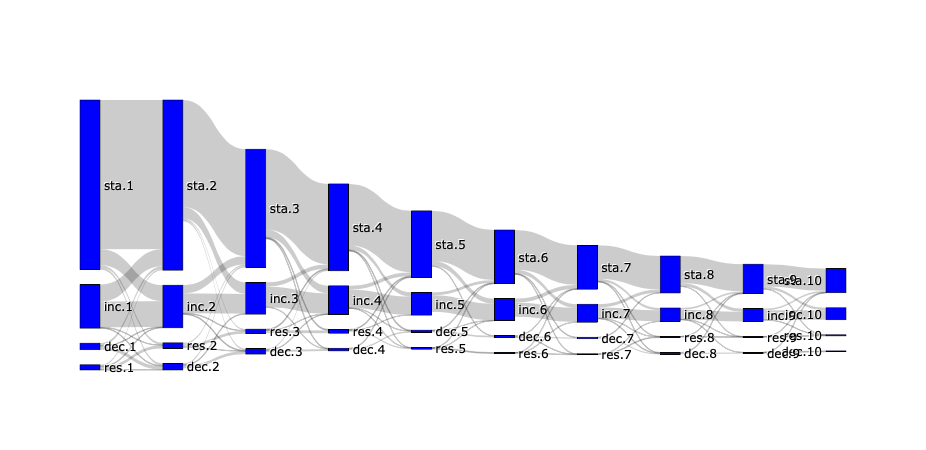

Findings: 
* Most patients have a stable status change reported, for many of them stable is the only status ever reported (see the Venn diagram) 
* For the patients reported as stable (sta), the next report is usually stable again, followed by increased (inc).  See the Sankey diagram. 
  
### 2.i. Can pre-malignancy (AAH/AIS) also be curated from pathology report for the GGO cohort instead of just the radiology report?  
Answer:
* Pre-malignancy data (i.e. AAH/AIS) are available in billing data and pathology/other notes. We have premalignancy conditions extracted in GGO reports for this project. 

### 2.j. Identification of a persistent GGO cohort
Approach: 
* Patients with multiple GGO reports, except for those with the last status changed reported as resolved. 
* Or patients with only one GGO report, but reported with a worsened status (number, size or solidity). 

Results: 
* The persistent cohort can be found as a view: v_s4_persistent_cohort. 
* For convenience, the persistent info can also be found in the view for note summary: v_s4_notes_ggo_summary. 

In [61]:
query = """
select d_person_id
, date_count total_reports
-- , radiology_reports 
, cohort
from notes_ggo
join (
    select d_person_id, count(distinct note_date) as date_count, max(note_date) as note_date
    from notes_ggo
    group by d_person_id
) _date_sum using (d_person_id, note_date)
join v_s4_lca_cohort using d_person_id
order by d_person_id
;"""

In [62]:
query = """
select d_person_id, note_date latest_date, date_count, ggo_level1, ggo_level2
from notes_ggo
join (
    select d_person_id, count(distinct note_date) as date_count, max(note_date) as note_date
    from notes_ggo
    group by d_person_id
) _date_sum using (d_person_id, note_date)
order by d_person_id
;
"""
# pd.read_sql(query, connection)
tmp = connection.execute(f"""create or replace view _person_summary as {query}""")

In [63]:
query = """
select *
from (
    SELECT d_person_id
    from _person_summary
    where date_count >1
    and d_person_id not in (
        SELECT d_person_id
        from _person_summary
        where date_count >1 -- and not with resolved in the last day report
        and ggo_level1 = 'GGO_status_change' and ggo_level2 = 'resolved/disappeared'
    )
) as muti_not_resolved
union
select *
from (
    SELECT d_person_id
	from _person_summary
    where date_count=1 -- and with any stable/worsen reported
        and (
            (ggo_level1 = 'GGO_status_change' and ggo_level2 in ('stable/no change/persistent', 'increased/progressed'))
            or ( ggo_level1 = 'GGO_solidity' and ggo_level2 in ('stable','increased'))
        )
) as single_changed
;
"""
# pd.read_sql(query, connection)
tmp = connection.execute(f"""create or replace view v_s4_persistent_cohort as {query}""")

## v_s4_notes_ggo_summary: a report level summary of GGO.
* D_patient_id: patient identifier 
* Note_date: the deidentified note date 
* Term_types: the types of GGO_terms (pure, mixed) 
* Max_size: the maximal size (in mm) of the GGOs in the report 
* Locations: the body locations of the reported GGOs 
* potential_causes: the potential cause category 
* Status_changes: the GGO status change categorized (increase, decrease, stable, resolved, …) 
* Shape_margins: the shape of GGO margins (round, irregular, …) 
* Solidity_changes: the solidity change category if available 
* Numbers: the number of GGO as (single, multiple) 
* is_persistent: 'YES' if the patient has persistent GGO 

In [64]:
query = """select *
from (select distinct d_person_id, note_date from notes_ggo
) as note_info
left join (select d_person_id, note_date
    , group_concat(distinct ggo_level2 order by ggo_level2 separator ', ') as term_types
    from notes_ggo
    where ggo_level1='GGO_term'
    group by d_person_id, note_date
) as term using (d_person_id, note_date)
left join (select d_person_id, note_date
    , max(cast(ggo_level3 as decimal)) as max_size
    from notes_ggo
    where ggo_level1='GGO_size'
    group by d_person_id, note_date
) as size using (d_person_id, note_date)
left join  (select d_person_id, note_date
    , group_concat(distinct concat(COALESCE(ggo_level2, '_'), '::', COALESCE(ggo_level3, '_')) 
        order by concat(COALESCE(ggo_level2, '_'), '::', COALESCE(ggo_level3, '_')) separator ', ') as locations
    from notes_ggo
    where ggo_level1='GGO_location'
    group by d_person_id, note_date
) as loca using (d_person_id, note_date)
left join (select d_person_id, note_date
    , group_concat(distinct ggo_level2 order by ggo_level2 separator ', ') as potential_causes
    from notes_ggo
    where ggo_level1='GGO_potential_cause'
    group by d_person_id, note_date
) as caus using (d_person_id, note_date)
left join (select d_person_id, note_date
    , group_concat(distinct ggo_level2 order by ggo_level2 separator ', ') as shape_margins
    from notes_ggo
    where ggo_level1='GGO_shape_margin'
    group by d_person_id, note_date
) as shap using (d_person_id, note_date)
left join (select d_person_id, note_date
    , group_concat(distinct ggo_level2 order by ggo_level2 separator ', ') as solidity_changes
    from notes_ggo
    where ggo_level1='GGO_solidity'
    group by d_person_id, note_date
) as soli using (d_person_id, note_date)
left join (select d_person_id, note_date
    , group_concat(distinct ggo_level2 order by ggo_level2 separator ', ') as numbers
    from notes_ggo
    where ggo_level1='GGO_number'
    group by d_person_id, note_date
) as num using (d_person_id, note_date)
left join (select d_person_id, note_date
    , group_concat(distinct ggo_level2 order by ggo_level2 separator ', ') as status_changes
    from notes_ggo
    where ggo_level1='GGO_status_change'
    group by d_person_id, note_date
) as status_change using (d_person_id, note_date)
left join (select d_person_id, 'Yes' as is_persistent
    from v_s4_persistent_cohort) persistent using (d_person_id)
order by d_person_id, note_date
"""
#pd.read_sql(query, connection)
g = connection.execute(text(f"""create or replace view v_s4_notes_ggo_summary as {query}"""))

In [65]:
#check
pd.read_sql(f"""select * from v_s4_notes_ggo_summary""", connection)

,d_person_id,note_date,term_types,max_size,locations,potential_causes,shape_margins,solidity_changes,numbers,status_changes,is_persistent
0,143,19332,pure,7.0,right lung::upper,None,irregular/spiculated/poorly defined/ill defined,None,None,None,Yes
1,143,19537,"mixed, pure",7.0,"left lung::upper, right lung::upper",None,None,None,None,stable/no change/persistent,Yes
2,143,19542,pure,7.0,"left lung::upper, right lung::upper",None,None,None,None,None,Yes
3,143,19543,"mixed, pure",7.0,"left lung::upper, right lung::upper",None,None,None,None,stable/no change/persistent,Yes
4,143,19726,pure,7.0,"left lung::upper, right lung::upper",None,None,None,None,None,Yes
...,...,...,...,...,...,...,...,...,...,...,...
24998,9998672,26716,pure,NaN,None,None,None,None,None,None,Yes
24999,9998738,23513,pure,NaN,"left lung::lower, right lung::upper",other,None,None,None,None,Yes
25000,9998738,23538,pure,NaN,"left lung::lower, right lung::upper",other,None,None,None,None,Yes
25001,9999652,26982,pure,5.0,"right lung::lower, right lung::upper",None,None,None,None,None,Yes


In [ ]:
connection.close()
"""
#jupyter nbconvert ../note_ggo_views.ipynb --to html --no-input
#html edit: add 
.jp-Cell-outputWrapper { margin-left: 100px; }
just before the last </style>
# change the first img to width=500px
"""